In [1]:
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization

In [2]:
"""
https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/
"""
# Task 1 load train and test dataset
def load_dataset():
    """
    We know some things about the dataset.

    For example, we know that the images are all pre-aligned
    (e.g. each image only contains a hand-drawn digit),
    that the images all have the same square size of 28×28 pixels,
    and that the images are grayscale.

    Therefore, we can load the images and reshape the data arrays to have a single color channel.

    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))


    We also know that there are 10 classes and that classes are represented as unique integers.

    We can, therefore, use a one hot encoding for the class element of each sample,
    transforming the integer into a 10 element binary vector with a 1 for the index of the class value,
    and 0 values for all other classes.
    We can achieve this with the to_categorical() utility function.
    :return:
    """
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [3]:
# Task 2: scale pixels
def prep_pixels(train, test):
    """
    Prepare Pixel Data
    We know that the pixel values for each image in the dataset
    are unsigned integers in the range between black and white, or 0 and 255.

    A good starting point is to normalize the pixel values of grayscale images,
    e.g. rescale them to the range [0,1].
    This involves first converting the data type from unsigned integers to floats,
    then dividing the pixel values by the maximum value.

    :param train:
    :param test:
    :return:
    """
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [4]:
#Task 3: Define the CNN Model
def define_model():
    """

    Next, we need to define a baseline convolutional neural network model for the problem.

    The model has two main aspects: the feature extraction front end comprised
    of convolutional and pooling layers, and the classifier backend that will make a prediction.

    For the convolutional front-end, we can start with a single convolutional
    layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. The filter maps can then be flattened to provide features to the classifier.

    Given that the problem is a multi-class classification task,
    we know that we will require an output layer with 10 nodes
    in order to predict the probability distribution of an image belonging to each of the 10 classes.
    This will also require the use of a softmax activation function.
    Between the feature extractor and the output layer, we can add a dense layer to interpret the features, in this case with 100 nodes.

    All layers will use the ReLU activation function and the He weight
    initialization scheme, both best practices.

    We will use a conservative configuration
    for the stochastic gradient descent optimizer with a learning rate of 0.01
    and a momentum of 0.9. The categorical cross-entropy loss function will be optimized,
    suitable for multi-class classification, and we will monitor the classification accuracy metric,
    which is appropriate given we have the same number of examples in each of the 10 classes.

    The define_model() function below will define and return this model.
    :return:
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
#Task 4: Evaluate the Model Using K-Fold Cross-Validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    """
    The performance of a model can be taken as the mean performance across k-folds, 
    given the standard deviation, that could be used to estimate a confidence interval if desired.

    We can use the KFold class from the scikit-learn API to 
    implement the k-fold cross-validation evaluation of a given neural network model. 
    
    After the model is defined, we need to evaluate it.

    The model will be evaluated using five-fold cross-validation. 
    The value of k=5 was chosen to provide a baseline for both 
    repeated evaluation and to not be so large as to require a 
    long running time. Each test set will be 20% of the training dataset, 
    or about 12,000 examples, close to the size of the actual test set for this problem.
    
    The training dataset is shuffled prior to being split, 
    and the sample shuffling is performed each time, 
    so that any model we evaluate will have the same train 
    and test datasets in each fold, providing an apples-to-apples comparison between models.
    
    We will train the baseline model for a modest 10 training 
    epochs with a default batch size of 32 examples. The test set 
    for each fold will be used to evaluate the model
     both during each epoch of the training run, so that we can later create learning curves, 
     and at the end of the run, so that we can estimate the performance of the model. 
     As such, we will keep track of the resulting history from each run, as well as the classification accuracy of the fold.
    
    The evaluate_model() function below implements these behaviors, 
    taking the training dataset as arguments and returning
     a list of accuracy scores and training histories that can be later summarized.
     
    """
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX,
                            trainY,
                            # please try the epoch at least = 10,
                            # we don't want to waste too much time on the lab, so use 3
                            epochs=3,
                            batch_size=32,
                            validation_data=(testX, testY),
                            verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

In [6]:
#Task 5: Visualisation of the Results
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    """
    Once the model has been evaluated, we can present the results.

    There are two key aspects to present:
     the diagnostics of the learning behavior of the model during
     training and the estimation of the model performance.
     These can be implemented using separate functions.

    First, the diagnostics involve creating a line plot showing model
    performance on the train and test set during each fold of the k-fold cross-validation.
     These plots are valuable for getting an idea of whether a model is overfitting,
     underfitting, or has a good fit for the dataset.

    We will create a single figure with two subplots, one for loss and one for accuracy.
    Blue lines will indicate model performance on the training dataset and orange
    lines will indicate performance on the hold out test dataset.
    The summarize_diagnostics() function below creates and shows this plot given
    the collected training histories.
    :param histories:
    :return:
    """
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(2, 1, 1)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        pyplot.subplot(2, 1, 2)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')

    pyplot.show()

In [7]:
#Task 6: Summarize the Model Performance
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores) * 100, std(scores) * 100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()


> 97.920
> 97.740
> 98.385


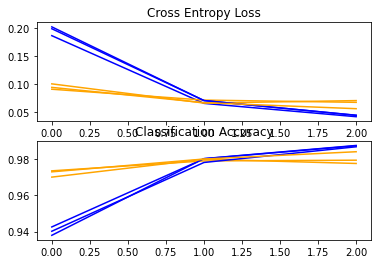

Accuracy: mean=98.015 std=0.272, n=3


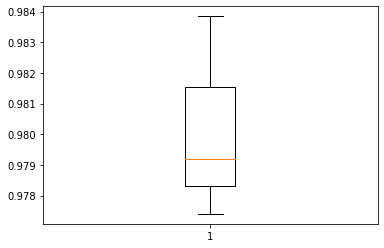

In [8]:
# Task 7: Run the test function for evaluating a model
def run_test():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    # Use k=3 to save time for now
    scores, histories = evaluate_model(trainX, trainY, 3)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)


# entry point, run the test harness
run_test()

In [9]:
"""
You can try the other models as follows,

# another model with BatchNormalization
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model


# another model with more layers (Increase in Model Depth)
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model
"""

"\nYou can try the other models as follows,\n\n# another model with BatchNormalization\ndef define_model():\n\tmodel = Sequential()\n\tmodel.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))\n\tmodel.add(BatchNormalization())\n\tmodel.add(MaxPooling2D((2, 2)))\n\tmodel.add(Flatten())\n\tmodel.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))\n\tmodel.add(BatchNormalization())\n\tmodel.add(Dense(10, activation='softmax'))\n\t# compile model\n\topt = SGD(lr=0.01, momentum=0.9)\n\tmodel.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])\n\treturn model\n\n\n# another model with more layers (Increase in Model Depth)\ndef define_model():\n\tmodel = Sequential()\n\tmodel.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))\n\tmodel.add(MaxPooling2D((2, 2)))\n\tmodel.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))\n\tmodel.